# Project 3: Can a car jump over a bridge gap?


You find yourself coming upon London Bridge, trying to make it to your DJ set at the Steel Yard Nightclub within the next half hour. Sneakily, you increase your speed to 30 mph (just 10 mph above the speed limit). SUDDENLY, you hear sirens behind you! You can't afford to lose your gig because DJs barely make a living, so you speed up to 67 mph (a comfortable speed for your BMW series 3 Sedan) and ALAS, the London Bridge starts lifting. Will you make it over? What if you had a different car? Would the angle of the bridge affect you? What if you had gunned it just a little harder or slower? 

In [83]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# import functions from the matplotlib module
import matplotlib.pyplot as plt
import math as math
from colour import Color

In [84]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree
radian = UNITS.radian

<Unit('radian')>

In [85]:
params = Params(x = 0 * m, 
                y = 1 * m,
                l = 4.64 * m,
                w = 1.81 * m,
                h = 1.43 * m,
                g = 9.8 * m/s**2,
                mass = 1528.6 * kg,
                rho = 1.2 * kg/m**3,
                C_d = 0.29,
                angle = 45 * degree,
                velocity = 30 * m / s,
                t_end = 1000 * s)

,values
x,0 meter
y,1 meter
l,4.64 meter
w,1.81 meter
h,1.43 meter
g,9.8 meter / second ** 2
mass,1528.6 kilogram
rho,1.2 kilogram / meter ** 3
C_d,0.29
angle,45 degree


In [86]:
def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = l * w
    
    return System(params, init=init, area=area)

In [87]:
system = make_system(params)

,values
x,0 meter
y,1 meter
l,4.64 meter
w,1.81 meter
h,1.43 meter
g,9.8 meter / second ** 2
mass,1528.6 kilogram
rho,1.2 kilogram / meter ** 3
C_d,0.29
angle,45 degree


In [88]:
def drag_force(v, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity Vector
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * v.mag**2 * C_d * area / 2
    direction = v.hat()
    f_drag = direction * mag
    return f_drag

In [89]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    v = Vector(vx, vy)    
    a_drag = drag_force(v, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

In [90]:
slope_func(system.init, 0, system)

(<Quantity(21.213203435596427, 'meter / second')>,
 <Quantity(21.213203435596427, 'meter / second')>,
 <Quantity(-0.6083863480105576, 'meter / second ** 2')>,
 <Quantity(-10.40838634801056, 'meter / second ** 2')>)

In [91]:
def event_func(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y

In [92]:
def height_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    x_dist = get_last_value(results.x) * m
    return x_dist

In [93]:
height_func(80, params)

<Quantity(29.587956118910462, 'meter')>

In [94]:
def gap_func(angle):
    base = 112 * math.cos(math.radians(angle))
    gap = 224 - base*2
    return gap
    

In [95]:
gap_func(86)

208.37454988131594

In [96]:
def run_ode(params):
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func, max_step = 0.2*s)
        
    return results

In [97]:
def sweep_angle(params, val_array):
    
    from colour import Color
    red = Color('red')
    color_range = list(red.range_to(Color('purple'), len(val_array)))

    for (angle, color) in zip(val_array, color_range):
        params = Params(params, angle=angle)
        res = run_ode(params)
        x_dist = res.x
        y_dist = res.y
        plot (x_dist, y_dist, color=color.rgb, label=str(angle))
        decorate(title="Sweeping through Angles Showing the Path of the Car")

In [98]:
def sweep_velocity(params, val_array):
    
    from colour import Color
    red = Color('red')
    color_range = list(red.range_to(Color('purple'), len(val_array)))

    for (velocity, color) in zip(val_array, color_range):
        params = Params(params, angle=45, velocity=velocity)
        res = run_ode(params)
        x_dist = res.x
        y_dist = res.y
        plot (x_dist, y_dist, color=color.rgb, label=str(velocity) + " m/s")
        decorate(title="Sweeping through Velocity Showing the Path of the Car")

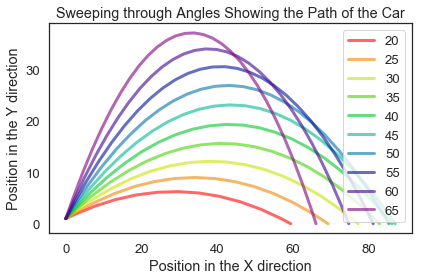

In [99]:
decorate(xlabel='Position in the X direction',
         ylabel='Position in the Y direction')

angle_array = linrange(20, 70, 5)
sweep_angle(params, angle_array)

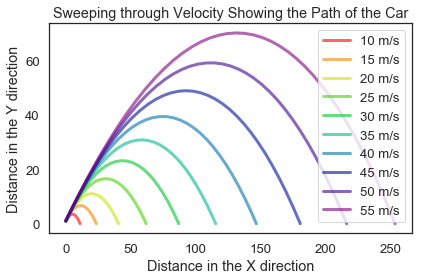

In [100]:
decorate(xlabel='Distance in the X direction',
         ylabel='Distance in the Y direction')

vel_array = linrange(10, 58, 5)
sweep_velocity(params, vel_array)

### This graph above assumes a constant angle 45 degrees

# London Bridge
## Stats:
- Total length: 224 meters
- Gap: 208 meters
- Maximum Angle: 86 degrees

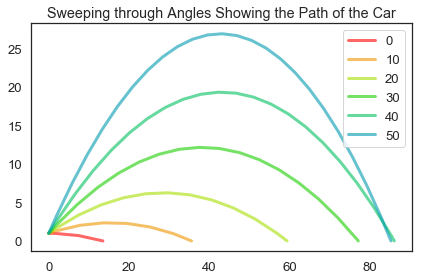

In [101]:
val_array = linrange(0, 90, 10)
red = Color('red')
color_range = list(red.range_to(Color('purple'), len(val_array)))

for (angle, color) in zip(val_array, color_range):
    params = Params(params, angle=angle)
    res = run_ode(params)
    x_dist = res.x
    y_dist = res.y
    if gap_func(angle) < get_last_value(res.x):
        plot (x_dist, y_dist, color=color.rgb, label=str(angle))
    decorate(title="Sweeping through Angles Showing the Path of the Car")
    """
    print("Gap Size: ", gap_func(26))
    print("X-distance (Min Angle): ", get_last_value(res.x))
    """

In [102]:
results, details = run_ode_solver(system, slope_func, events=event_func, max_step = 0.2*s)

In [103]:
"""plot(results.x, label='x', color='orange')
plot(results.y, label='y', color='green')

decorate(title='Position v. Time Graph',
         xlabel='Time (s)',
         ylabel='Position (m)')"""

"plot(results.x, label='x', color='orange')\nplot(results.y, label='y', color='green')\n\ndecorate(title='Position v. Time Graph',\n         xlabel='Time (s)',\n         ylabel='Position (m)')"

In [104]:
"""plot (results.x, results.y, color='blue')

decorate(title='X Postion v. Y Position Graph',
         xlabel='X Position (m)',
         ylabel='Y Position (m)')"""

"plot (results.x, results.y, color='blue')\n\ndecorate(title='X Postion v. Y Position Graph',\n         xlabel='X Position (m)',\n         ylabel='Y Position (m)')"

In [105]:
"""plot(results.vx, label='vx', color='purple')
plot(results.vy, label='vy', color='red')

decorate(title='Velocity v. Time Graph',
         xlabel='Time (s)',
         ylabel='Velocity (m/s)')"""

"plot(results.vx, label='vx', color='purple')\nplot(results.vy, label='vy', color='red')\n\ndecorate(title='Velocity v. Time Graph',\n         xlabel='Time (s)',\n         ylabel='Velocity (m/s)')"

In [106]:
"""plot (results.vx, results.vy, color="indigo")

decorate(title='Velocity (X) v. Velocity (Y) Graph',
         xlabel='X Velocity (m/s)',
         ylabel='Y Veloctiy (m/s)')"""

'plot (results.vx, results.vy, color="indigo")\n\ndecorate(title=\'Velocity (X) v. Velocity (Y) Graph\',\n         xlabel=\'X Velocity (m/s)\',\n         ylabel=\'Y Veloctiy (m/s)\')'